## Imports

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


# Hyperparameters
latent_size = 100
channels = 3
hidden_size = 64
image_size = 32

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified


## The next 5 blocks have the code for FID score calculation

In [11]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import matplotlib.animation as animation
from IPython.display import HTML

from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image

import matplotlib.pyplot as plt
import sys
import numpy as np
import os
# print(os.listdir("../input"))

import time

In [12]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def calculate_activation_statistics(images,model,batch_size=32, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [14]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [15]:
def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
#      """get fretched distance"""
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

## Generator Block

**This block has 4 convTranspose layer followed by ReLu and Batch Normalization and 1 Convolution Layer followed by BatchNorm and Tanh Activation**

In [7]:
# The inputs for nn.ConvTranspose2d are:

# in_channels: The number of channels in the input image.
# out_channels: The number of channels produced by the convolution.
# kernel_size: The size of the convolving kernel.
# stride: The stride of the convolution.
# padding: The amount of padding added to the input.

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(latent_size, 512, 4, 1, 0,bias=False)
        self.batchnorm1 = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(True)
        
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1,bias=False)
        self.batchnorm2 = nn.BatchNorm2d(256)
        
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1,bias = False)
        self.batchnorm3 = nn.BatchNorm2d(128)
    
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1,bias = False)
        self.batchnorm4 = nn.BatchNorm2d(64)        
        
        self.conv5 = nn.Conv2d(64, 3, 3, 1, 1,bias=False)
        self.batchnorm5 = nn.BatchNorm2d(3)  
        
        self.tanh = nn.Tanh()
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.conv4(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.conv5(out)
        out = self.batchnorm5(out)
        out = self.tanh(out)
        return out

## Discrimator Block

**The Discriminator block has 5 conv blocks with Batch Normalization and LeakyRelU activation function (except for last block which is followed by sigmoid activation)**

In [8]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(channels, hidden_size, 4, 2, 1, bias = False)
        self.leakyrelu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size * 2, 4, 2, 1, bias = False)

        self.batchnorm2 = nn.BatchNorm2d(hidden_size * 2)
        self.leakyrelu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.Conv2d(hidden_size * 2, hidden_size * 4, 4, 2, 1, bias = False)
        self.conv6 = nn.Conv2d(hidden_size * 4, hidden_size * 4, 3, 1, 1, bias = False)
        self.batchnorm3 = nn.BatchNorm2d(hidden_size * 4)
        self.leakyrelu3 = nn.LeakyReLU(0.2, inplace=True)
        self.conv4 = nn.Conv2d(hidden_size * 4, hidden_size * 8, 4, 2, 1, bias = False)
        self.batchnorm4 = nn.BatchNorm2d(hidden_size * 8)
        self.leakyrelu4 = nn.LeakyReLU(0.2, inplace=True)
        self.conv5 = nn.Conv2d(hidden_size * 8, 1, 2, 1, 0,bias = False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.conv1(x)
        out = self.leakyrelu1(out)
        out = self.conv2(out)
        
        out = self.batchnorm2(out)
        out = self.leakyrelu2(out)
        out = self.conv3(out)
        out = self.conv6(out)
        out = self.batchnorm3(out)
        out = self.leakyrelu3(out)
        out = self.conv4(out)
        out = self.batchnorm4(out)
        out = self.leakyrelu4(out)
        out = self.conv5(out)
        out = out.flatten(start_dim=1)
        out = self.sigmoid(out)
        
        return out

## Model Summary

In [9]:
!pip install torchsummary
from torchsummary import summary
generator1 = Generator().to(device)
discriminator1 = Discriminator().to(device)
summary(generator1, (latent_size, 1, 1))
summary(discriminator1, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13            [-1, 3, 32, 32]           1,728
      BatchNorm2d-14            [-1, 3,

## Learning Rate Test

**Conducting the test for 4 different learning rates and for 70 epochs**  
**Used Binary Cross Entropy Loss function and Adam Optimizer and Batch_+size=32**

**In the code d_loss denotes discriminator loss (used for back propagation for discriminator) and g_loss denotes generator loss (used for backpropagation for generator)**

In [10]:
lrs = [0.00001,0.0001,0.001,0.01]

ds = []
gs = []
gimgs = []
fds = []
num_epochs = 70
batch_size = 32


for learning_rate in lrs:
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    # Loss function
    criterion = nn.BCELoss()

    # Optimizers
    optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

    generator.train()
    discriminator.train()

    d = []
    g = []
    fd = []

    # Start training
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(train_loader):
            images = images.to(device)

            # Train discriminator with real images
            discriminator.zero_grad()
            outputs = discriminator(images)
            real_labels = torch.ones(images.size(0),1).to(device)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            # Train discriminator with fake images
            z = torch.randn(images.size(0), latent_size, 1, 1).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())
            fake_labels = torch.zeros(images.size(0),1).to(device)
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()

            # Update discriminator parameters
            d_loss = d_loss_real + d_loss_fake
            optimizer_d.step()

            # Train generator
            generator.zero_grad()
            outputs = discriminator(fake_images)
            real_labels = torch.ones(images.size(0), 1).to(device)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()

            # Update generator parameters
            optimizer_g.step()

            # Print progress
            if (i+1) % 20 == 0:
                total_steps = len(train_loader) * (epoch+1)
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}",end='\r')
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")
        fretchet_dist=calculate_fretchet(images,fake_images,model) 
#         print(fretchet_dist)

        fd.append(fretchet_dist)
        d.append(d_loss.cpu().detach().numpy())
        g.append(g_loss.cpu().detach().numpy())

        
    ds.append(d)
    gs.append(g)
    fds.append(fd)
    generator.eval()
    z = torch.randn(25, latent_size, 1, 1).to(device)
    generated_images = generator(z)
    gimgs.append(generated_images.data)


Epoch [1/70], Step [1563/1563], d_loss: 0.0202, g_loss: 6.3211

Epoch [2/70], Step [1563/1563], d_loss: 0.3087, g_loss: 2.9727

Epoch [3/70], Step [1563/1563], d_loss: 0.0858, g_loss: 4.0166

Epoch [4/70], Step [1563/1563], d_loss: 0.8514, g_loss: 1.9305

Epoch [5/70], Step [1563/1563], d_loss: 0.1270, g_loss: 2.6458

Epoch [6/70], Step [1563/1563], d_loss: 0.2488, g_loss: 3.7383

Epoch [7/70], Step [1563/1563], d_loss: 0.3329, g_loss: 3.4834

Epoch [8/70], Step [1563/1563], d_loss: 0.1271, g_loss: 2.9829

Epoch [9/70], Step [1563/1563], d_loss: 0.2296, g_loss: 3.2195

Epoch [10/70], Step [1563/1563], d_loss: 0.2614, g_loss: 2.0249

Epoch [11/70], Step [1563/1563], d_loss: 0.3461, g_loss: 2.9241

Epoch [12/70], Step [1563/1563], d_loss: 0.2972, g_loss: 3.2513

Epoch [13/70], Step [1563/1563], d_loss: 0.0310, g_loss: 4.1801

Epoch [14/70], Step [1563/1563], d_loss: 1.1972, g_loss: 1.7721

Epoch [15/70], Step [1563/1563], d_loss: 0.0384, g_loss: 4.4154

Epoch [16/70], Step [1563/1563], d

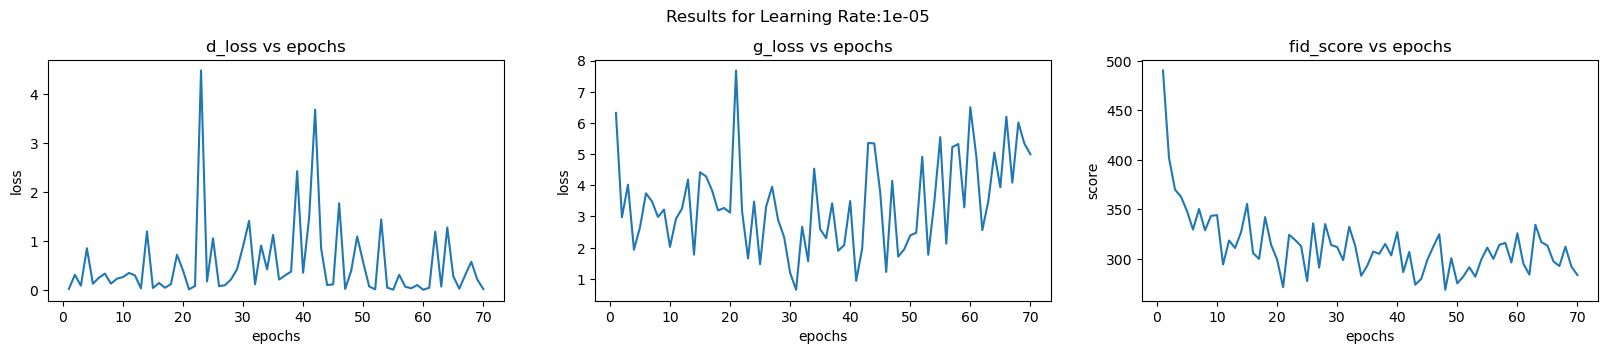

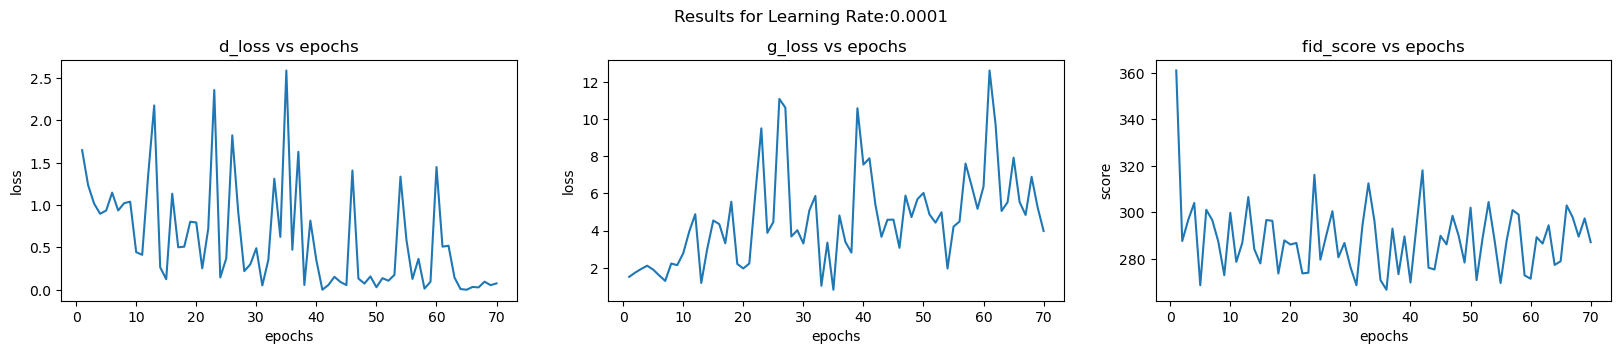

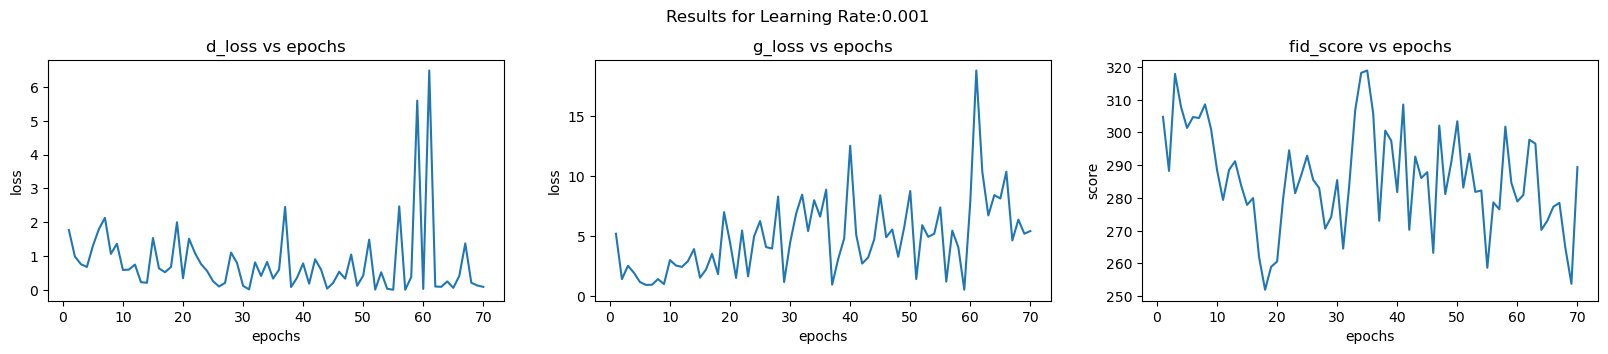

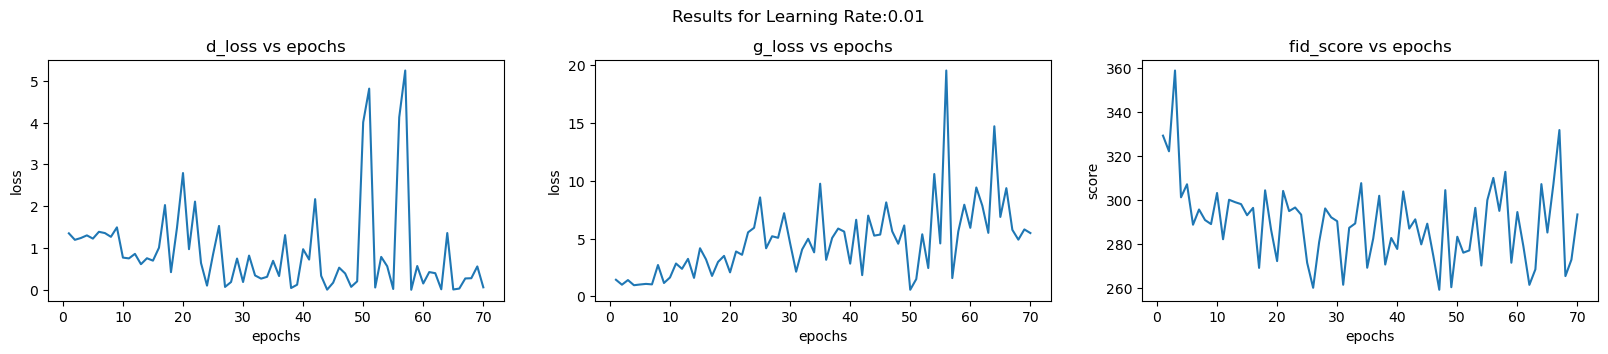

In [11]:
e = [i for i in range(1,num_epochs+1)]

for i,lr in enumerate(lrs):
    fig1 = plt.figure(figsize = (20,10))
    fig1.suptitle('Results for Learning Rate:{}'.format(lr))
    ax1 = fig1.add_subplot(3,3,1)
    ax1.set(title = "d_loss vs epochs",xlabel = 'epochs',ylabel = 'loss')
    ax2 = fig1.add_subplot(3,3,2)
    ax3 = fig1.add_subplot(3,3,3)
    ax2.set(title = "g_loss vs epochs",xlabel = 'epochs',ylabel = 'loss')
    ax3.set(title = "fid_score vs epochs",xlabel='epochs',ylabel='score')
    ax1.plot(e,ds[i])
    ax2.plot(e,gs[i])
    ax3.plot(e,fds[i])
    plt.subplots_adjust(top=0.93)
    plt.show()

lr: 1e-05


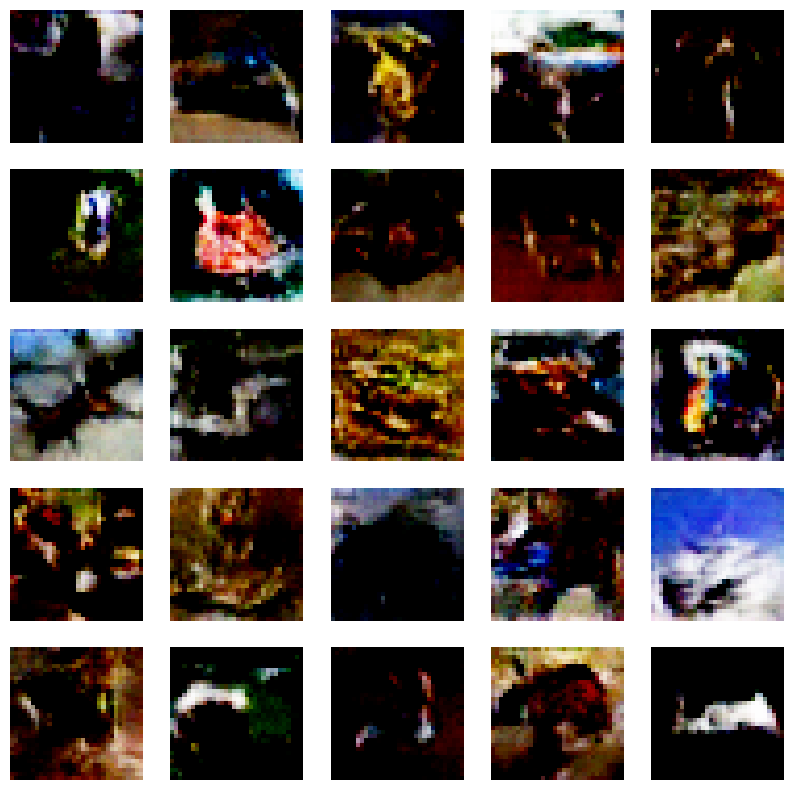

lr: 0.0001


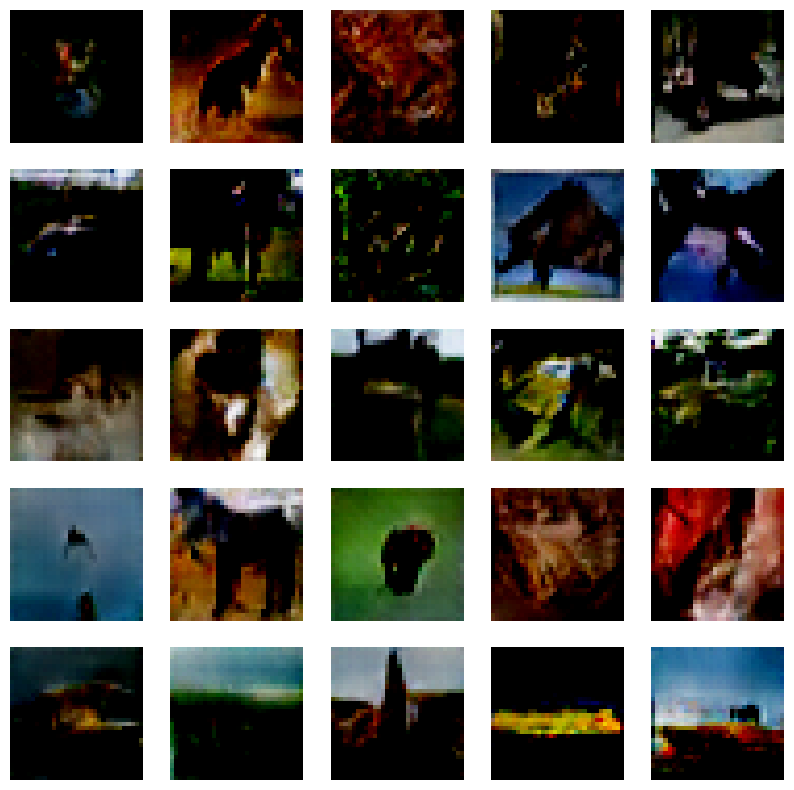

lr: 0.001


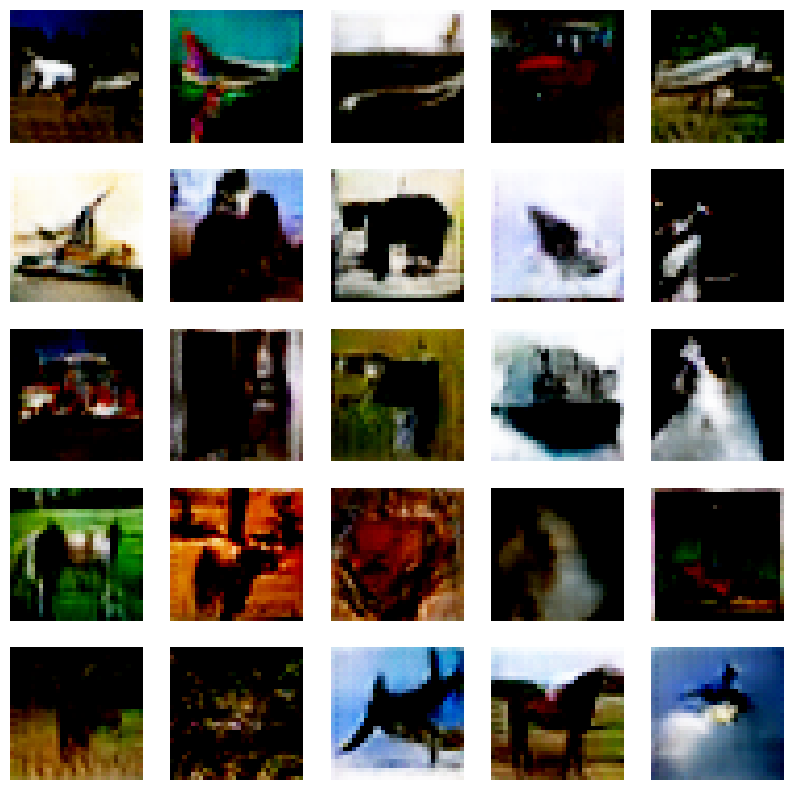

lr: 0.01


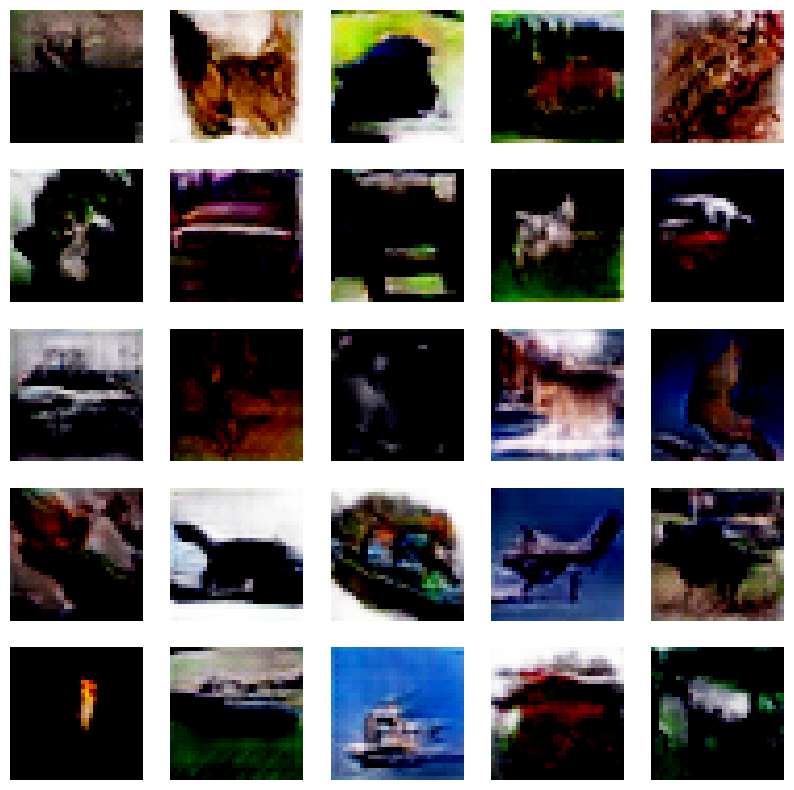

In [12]:
from torchvision.utils import save_image
for i,data in enumerate(gimgs):
    print("lr:",lrs[i])
    save_image(data, "generated_images_lr_{}.png".format(lrs[i]), nrow=5, normalize=True)
    
    fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

    for j, ax in enumerate(axs.flatten()):
        ax.imshow(np.transpose(data.cpu()[j], (1, 2, 0)))
        ax.axis('off')
    plt.show()

### It can be observed from the discriminator loss, generator loss, FID score and from the images generated that a learning rate of 0.001 is better

## Training and Plotting Generator output after few epochs

**Took num_epochs = 40, since in the previous plot it can be seen that results for num_epochs equal to 70 is almost same as 40**

Output before Training:


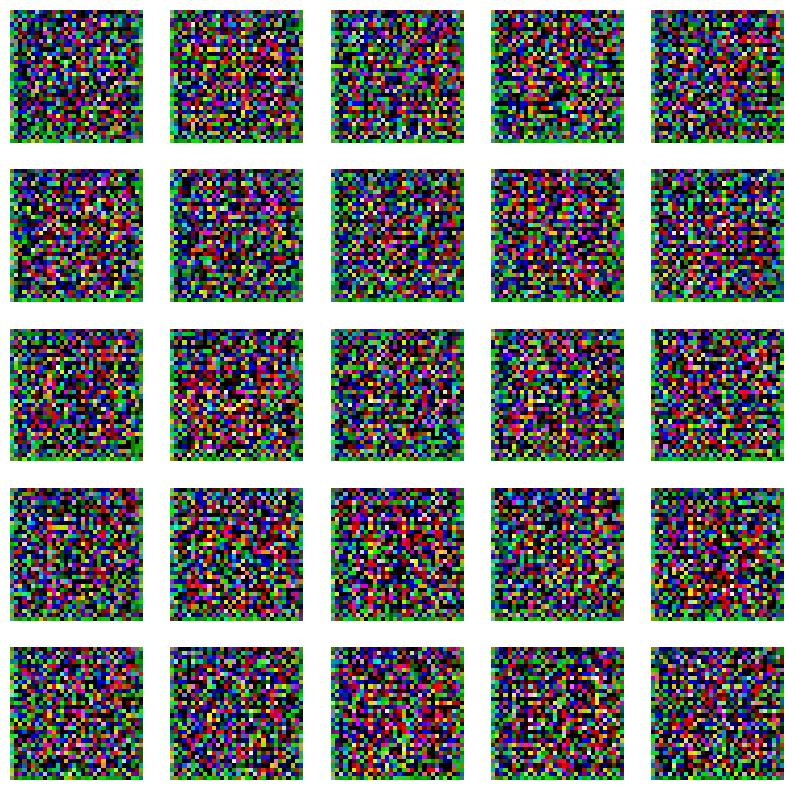

Output after epochs=1:


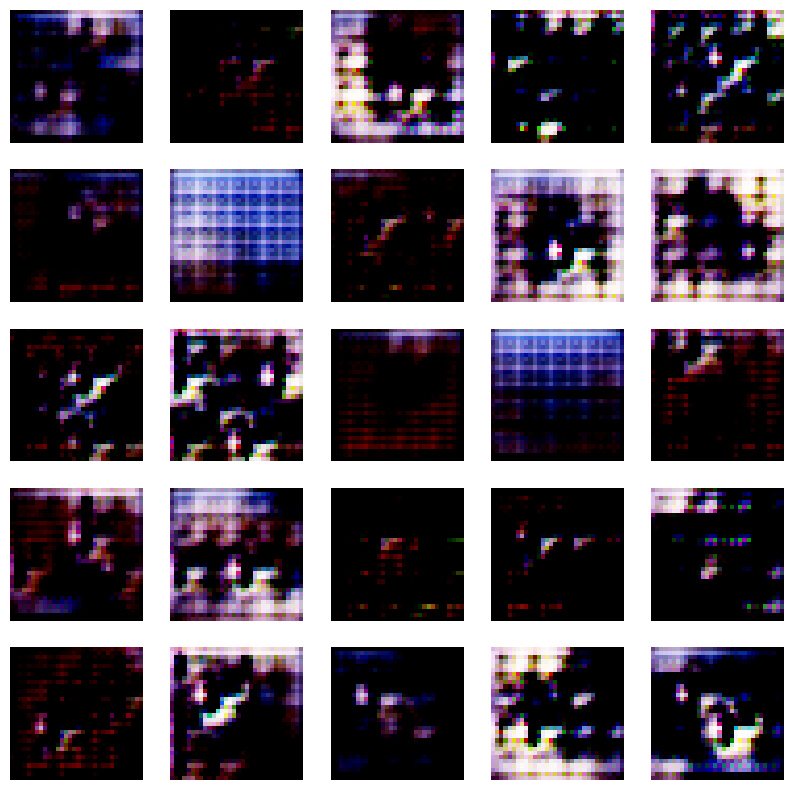

Output after epochs=2:


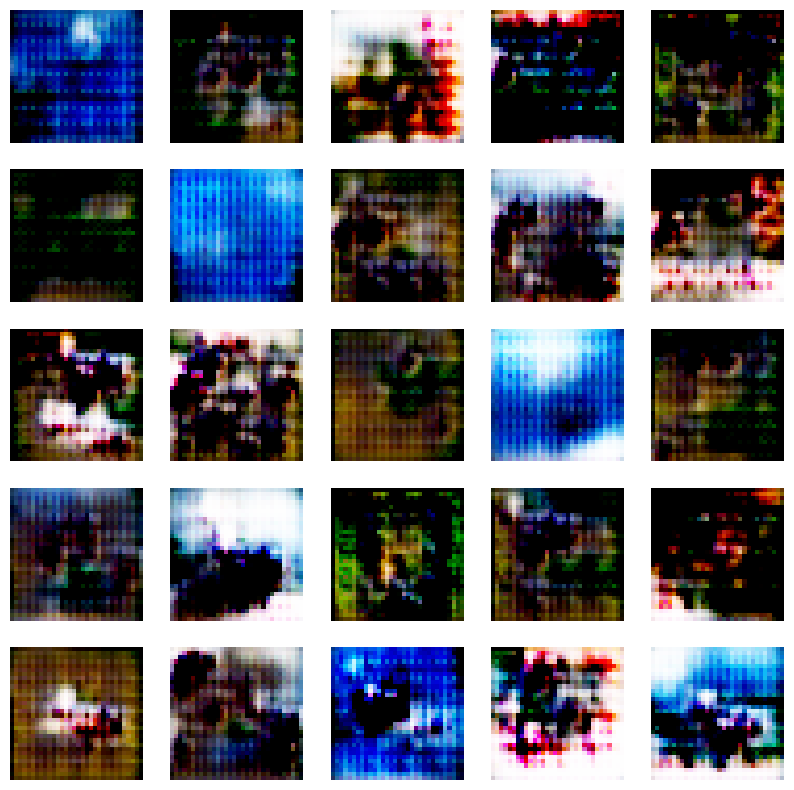

Output after epochs=5:


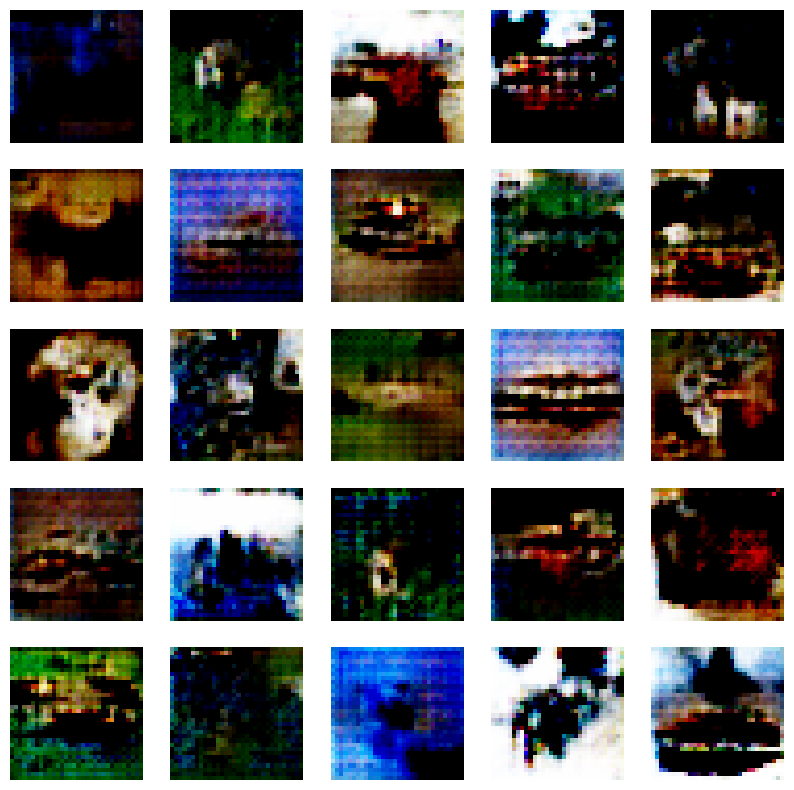

Output after epochs=15:


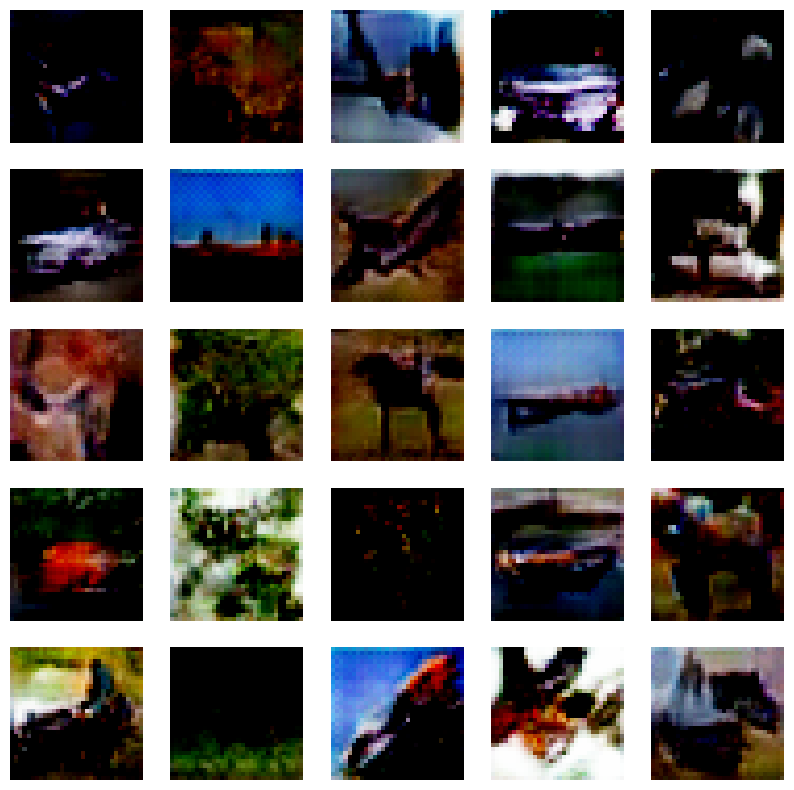

Output after epochs=25:


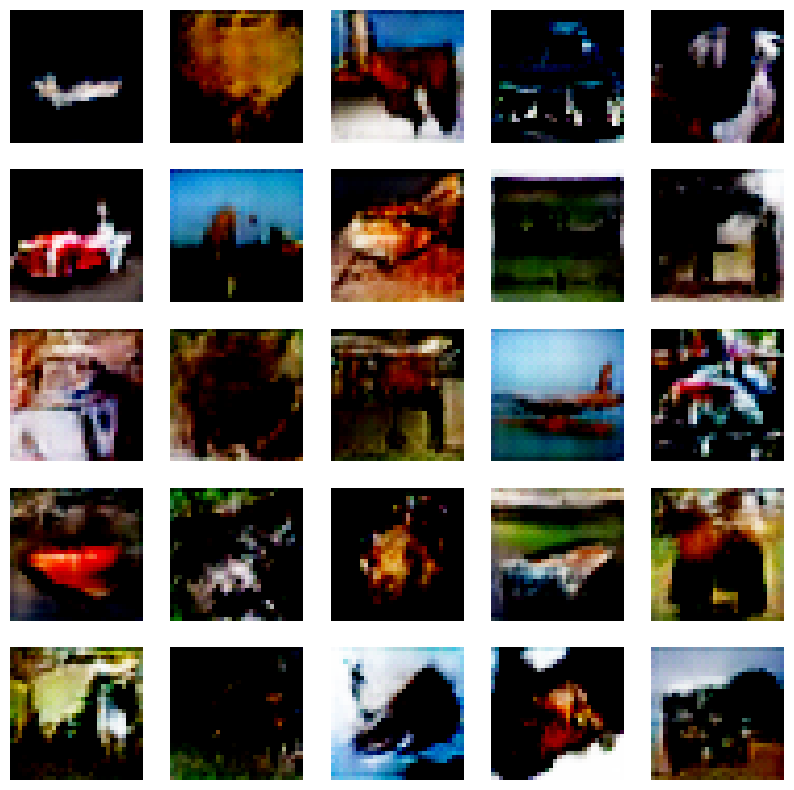

Output after epochs=35:


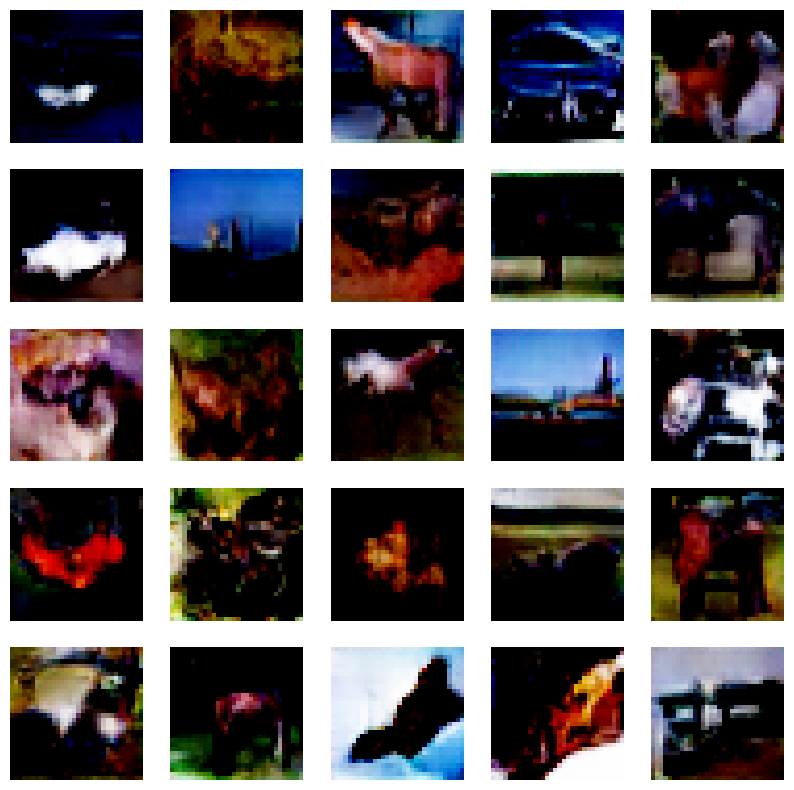

In [ ]:
num_epochs = 40
batch_size = 32
learning_rate = 0.001

z_global = torch.randn(25, latent_size, 1, 1).to(device)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))




discriminator.train()


fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

print("Output before Training:")

for j, ax in enumerate(axs.flatten()):
    ax.imshow(np.transpose(generator(z_global).data.cpu()[j], (1, 2, 0)))
    ax.axis('off')
plt.show()



# d = []
# g = []
# fd = []

ep = [1,2,5,15,25,35,45]
p = 0
# Start training
for epoch in range(num_epochs):
    generator.train()
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        # Train discriminator with real images
        discriminator.zero_grad()
        outputs = discriminator(images)
        real_labels = torch.ones(images.size(0),1).to(device)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        # Train discriminator with fake images
        z = torch.randn(images.size(0), latent_size, 1, 1).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        fake_labels = torch.zeros(images.size(0),1).to(device)
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()

        # Update discriminator parameters
        d_loss = d_loss_real + d_loss_fake
        optimizer_d.step()

        # Train generator
        generator.zero_grad()
        outputs = discriminator(fake_images)
        real_labels = torch.ones(images.size(0), 1).to(device)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()

        # Update generator parameters
        optimizer_g.step()
    generator.eval()
        
    if(epoch+1==ep[p]):
        print("Output after epochs={}:".format(ep[p]))
        p+=1

        fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
        for j, ax in enumerate(axs.flatten()):
            ax.imshow(np.transpose(generator(z_global).data.cpu()[j], (1, 2, 0)))
            ax.axis('off')
        plt.show()
        
generator.eval()
        
print("Output after Training:")

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for j, ax in enumerate(axs.flatten()):
    ax.imshow(np.transpose(generator(z_global).data.cpu()[j], (1, 2, 0)))
    ax.axis('off')
plt.show()
        